<a href="https://colab.research.google.com/github/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina/blob/main/Parcial_1_TAM_2025-1/notebooks/LinearRegressor_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:


# === CLONAR EL REPOSITORIO Y LISTAR SU CONTENIDO ===

# Clona el repositorio desde GitHub si no se ha hecho previamente.
# Esto permite acceder a los notebooks, datos y estructuras organizadas del proyecto.
!git clone https://github.com/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina.git



# Lista el contenido del directorio del parcial dentro del repositorio clonado
# para confirmar que la estructura y carpeta 'data' existen correctamente.
!ls /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1

fatal: destination path 'Teoria-de-Aprendizaje-Maquina' already exists and is not an empty directory.
dashboard  notebooks	  requirements.txt
data	   parte_teorica  resultados
figuras    README.md	  Teoria-de-Aprendizaje-Maquina


In [54]:

!ls /content/Teoria-de-Aprendizaje-Maquina

'Ejercicios TAM_2025-1'   Parcial_1_TAM_2025-1	 README.md


In [55]:
# === IMPORTACIÓN DE LIBRERÍAS Y CAMBIO DE DIRECTORIO ===

import os      # Para manipular rutas de archivos y cambiar directorios
import joblib  # Para cargar archivos serializados (como los .pkl que contienen los datos escalados)

# Carpeta base del repositorio (relativa o absoluta)
repo_folder = 'Teoria-de-Aprendizaje-Maquina'
partial_folder = 'Parcial_1_TAM_2025-1'

# Construir ruta completa al directorio parcial
target_dir = os.path.join(repo_folder, partial_folder)

# Obtener ruta actual para referencia
current_dir = os.getcwd()
print(f"Directorio actual: {current_dir}")

# Verificar que el directorio existe antes de cambiar
if os.path.isdir(target_dir):
    os.chdir(target_dir)
    print(f"Cambiado al directorio: {os.getcwd()}")
else:
    raise FileNotFoundError(
        f"No se encontró el directorio esperado: '{target_dir}'. "
        f"Asegúrate de haber clonado el repositorio en el directorio actual."
    )

# Definir ruta al archivo de datos relativo al directorio cambiado
data_path = os.path.join('data', 'train_test_scaled.pkl')

# Verificar que el archivo existe antes de cargarlo
if not os.path.exists(data_path):
    raise FileNotFoundError(
        f"No se encontró el archivo esperado en: {os.path.abspath(data_path)}"
    )
else:
    print(f"Archivo encontrado: {data_path}")


Directorio actual: /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1
Cambiado al directorio: /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1
Archivo encontrado: data/train_test_scaled.pkl


In [56]:
# === CARGA DE LOS DATOS PROCESADOS ===

# Carga el archivo .pkl que contiene los cuatro objetos: X_train_scaled, X_test_scaled, y_train, y_test
# Estos datos fueron escalados y divididos previamente en el notebook de preprocesamiento.
X_train_scaled, X_test_scaled, y_train, y_test = joblib.load(data_path)

# Confirmación visual de que la carga fue exitosa.
print("Datos cargados correctamente.")

%cd /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1

Datos cargados correctamente.
/content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1


In [57]:
# === IMPORTACIÓN DE LIBRERÍAS Y DEFINICIÓN DE MÉTRICAS PERSONALIZADAS ===

# ================================================================
#  IMPORTACIONES COMPLETAS – ESTUDIO DE REGRESORES AMES HOUSING
# ================================================================
!pip install scikit-optimize

# ============================
#  Utilidades generales
# ============================
import numpy as np
import pandas as pd
import time
import os
import warnings
warnings.filterwarnings("ignore")  # Opcional: suprime warnings en notebooks

# ============================
#  Modelos de regresión
# ============================
from sklearn.linear_model import (
    LinearRegression,
    Lasso, LassoCV,
    ElasticNet, ElasticNetCV,
    SGDRegressor,
    BayesianRidge
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
# Importaciones necesarias desde scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# ============================
#  Validación y búsqueda
# ============================
from sklearn.model_selection import (
    KFold,
    GridSearchCV,
    RandomizedSearchCV,
    learning_curve,
    cross_validate,
    cross_val_predict
)

# ============================
#  Métricas y scoring
# ============================
from sklearn.metrics import (
    mean_absolute_error,       # MAE
    mean_squared_error,        # MSE
    r2_score,                  # R²
    mean_absolute_percentage_error,  # MAPE
    make_scorer                # Para definir MAPE como scorer
)

# ============================
# Diagnóstico estadístico
# ============================
from scipy.stats import shapiro, kurtosis, skew
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# ============================
#  Visualización
# ============================
import matplotlib.pyplot as plt
import scipy.stats as stats  # necesario para pruebas estadísticas

import seaborn as sns

In [58]:
# === DEFINICIÓN DE MÉTRICA PERSONALIZADA: MAPE ===

# MAPE no está directamente disponible en sklearn, por lo que se define manualmente.
# Esta métrica mide el error absoluto medio en porcentaje, útil para interpretar desviaciones relativas.

def mean_absolute_percentage_error(y_true, y_pred):
    # Reemplaza ceros en y_true para evitar divisiones por cero (buena práctica numérica)
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Se integra la función MAPE a sklearn como un scorer compatible con cross_validate
# Se indica que un menor valor es mejor (greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [59]:

# === DEFINICIÓN DEL ESQUEMA DE VALIDACIÓN CRUZADA ===

# Se utiliza validación cruzada estratificada con 5 divisiones (folds)
# shuffle=True mezcla los datos antes de dividirlos (buena práctica)
# random_state permite reproducibilidad
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [60]:
# === DEFINICIÓN DE MÉTRICAS DE EVALUACIÓN PARA TODOS LOS MODELOS ===

# Las métricas estándar (MAE y MSE) son negativas en sklearn por convención (porque se busca minimizar)
# R² se mantiene tal cual
# MAPE se incluye como scorer personalizado
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2',
    'MAPE': mape_scorer
}

In [61]:
modelos = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3),
    "BayesianRidge": BayesianRidge(),
    "KernelRidge": KernelRidge(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GaussianProcess": GaussianProcessRegressor(),
    "SVR": SVR()
}

In [62]:
def evaluar_modelo_cv(nombre_modelo, modelo, X, y, cv, scoring, guardar_en=None):
    """
    Evalúa un modelo usando validación cruzada fold a fold,
    genera un DataFrame con resultados detallados y opcionalmente guarda el CSV.
    Ahora incluye una fila final 'Promedio' claramente etiquetada.
    """

    # Evaluación con validación cruzada
    resultados = cross_validate(
        estimator=modelo,
        X=X,
        y=y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )

    # Crear DataFrame por fold
    df_resultados = pd.DataFrame({
        "Fold": np.arange(1, cv.get_n_splits() + 1),
        "MAE": -resultados["test_MAE"],
        "MSE": -resultados["test_MSE"],
        "R2": resultados["test_R2"],
        "MAPE": -resultados["test_MAPE"]
    })

    # Fila promedio con etiqueta explícita
    promedio = df_resultados.mean(numeric_only=True)
    promedio["Fold"] = "Promedio"

    # Añadir al DataFrame
    df_resultados = pd.concat([df_resultados, pd.DataFrame([promedio])], ignore_index=True)

    # Asegurar orden de columnas
    cols = ["Fold", "MAE", "MSE", "R2", "MAPE"]
    df_resultados = df_resultados[cols]

    # Guardar si se indica
    if guardar_en:
        os.makedirs(os.path.dirname(guardar_en), exist_ok=True)
        df_resultados.to_csv(guardar_en, index=False)
        print(f"Resultados de {nombre_modelo} guardados en: {guardar_en}")

    return df_resultados




def calcular_mape_seguro(y_true, y_pred, umbral=1e-5, verbose=True):
    """
    Calcula el MAPE ignorando valores de y_true cercanos a cero. Devuelve el MAPE (%) y el número de observaciones usadas.

    Parámetros:
    ----------
    y_true : array-like
        Valores reales en escala original.

    y_pred : array-like
        Valores predichos en escala original.

    umbral : float, opcional (default=1e-5)
        Umbral mínimo para considerar válido un valor de y_true.

    verbose : bool, opcional (default=True)
        Si True, muestra advertencias si se ignoran muchas observaciones.

    Retorna:
    -------
    mape : float
        MAPE en porcentaje (%)

    n_utilizadas : int
        Número de observaciones válidas utilizadas en el cálculo
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Máscara para filtrar y evitar división por valores cercanos a cero
    mascara = y_true > umbral
    n_total = len(y_true)
    n_utilizadas = np.sum(mascara)

    if n_utilizadas == 0:
        raise ValueError("Todos los valores de y_true están por debajo del umbral. No se puede calcular el MAPE.")

    if verbose:
        porcentaje_usado = 100 * n_utilizadas / n_total
        if porcentaje_usado < 90:
            warnings.warn(f"Solo se usó el {porcentaje_usado:.2f}% de las observaciones para calcular el MAPE. "
                          "Revisa posibles valores extremos en y_true.")

    mape = np.mean(np.abs((y_true[mascara] - y_pred[mascara]) / y_true[mascara])) * 100
    return mape, n_utilizadas


def normalizar_metricas(mae, rmse, y_true):
    media_y = np.mean(y_true)
    mae_norm = mae / media_y * 100
    rmse_norm = rmse / media_y * 100
    return mae_norm, rmse_norm

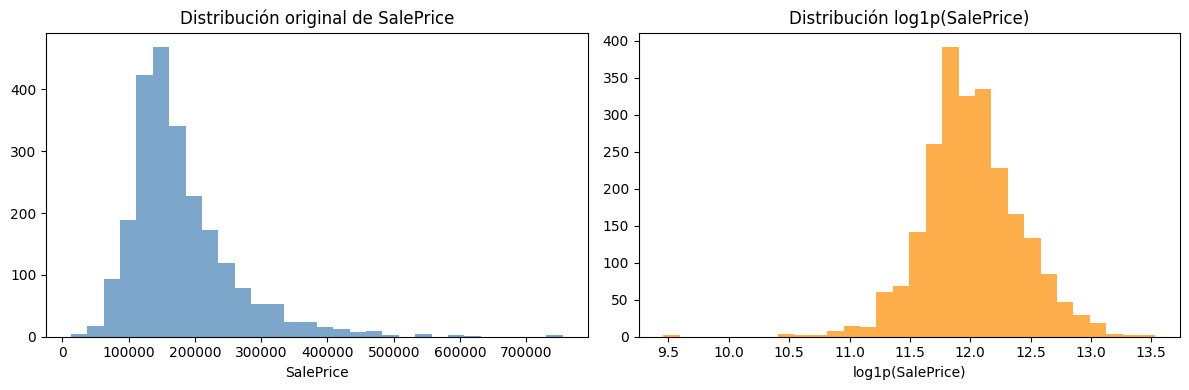

In [63]:
# Asegurar que es numpy array 1D plano
y_train_array = np.array(y_train).flatten()

plt.figure(figsize=(12, 4))

# Histograma datos originales
plt.subplot(1, 2, 1)
plt.hist(y_train_array, bins=30, color="steelblue", alpha=0.7)
plt.title("Distribución original de SalePrice")
plt.xlabel("SalePrice")

# Histograma datos log-transformados
plt.subplot(1, 2, 2)
plt.hist(np.log1p(y_train_array), bins=30, color="darkorange", alpha=0.7)
plt.title("Distribución log1p(SalePrice)")
plt.xlabel("log1p(SalePrice)")

plt.tight_layout()
plt.show()


## Transformación de la variable objetivo: `SalePrice`

El análisis inicial mostró que la variable `SalePrice` presenta una distribución fuertemente asimétrica hacia la derecha (positivamente sesgada), como se evidencia en el histograma de la izquierda. Esta asimetría implica que los precios más altos son mucho más dispersos y menos frecuentes, mientras que la mayoría de las observaciones se concentran en valores más bajos.

Este tipo de distribución sesgada puede afectar negativamente el rendimiento de los modelos lineales, que asumen linealidad y homocedasticidad (varianza constante del error). En particular, puede provocar:

- Residuos no normalmente distribuidos
- Violación del supuesto de varianza constante
- Influencia excesiva de outliers en la predicción

### Justificación de la transformación logarítmica

Para mitigar estos efectos, se aplicó la transformación `log1p(SalePrice)`, que calcula `log(1 + SalePrice)`. Esta transformación tiene dos ventajas:

1. **Reduce la asimetría de la distribución**, aproximándola a una forma más simétrica y cercana a la normalidad.
2. **Preserva las relaciones relativas entre los valores**, facilitando que los coeficientes de regresión reflejen efectos proporcionales.

En el histograma de la derecha se observa que `log1p(SalePrice)` presenta una forma mucho más simétrica, con un pico central definido y colas más equilibradas, cumpliendo con los supuestos de la regresión lineal.

En conclusión, la transformación logarítmica fue aplicada para estabilizar la varianza, mejorar la distribución de los residuos y garantizar que el modelo pueda capturar patrones de manera más eficiente y precisa.


In [64]:
# === IMPORTACIONES ===
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import KFold

# === CARGA DE DATOS DESDE PREPROCESAMIENTO ===
ruta_base = "data"
ruta_datos = os.path.join(ruta_base, "train_test_scaled.pkl")
if not os.path.exists(ruta_datos):
    raise FileNotFoundError(f"No se encontró el archivo de datos escalados: {ruta_datos}")

X_train_scaled, X_test_scaled, y_train, y_test = joblib.load(ruta_datos)

# === TRANSFORMACIÓN DE Y (log) ===
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# === CONFIGURACIÓN VALIDACIÓN CRUZADA ===
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# === FUNCIÓN VALIDACIÓN EN ESCALA ORIGINAL ===
def validar_linear_regression_original_scale(X, y_log, y_orig, cv):
    mae_list, mse_list, r2_list, mape_list = [], [], [], []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X), start=1):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold_log = y_log.iloc[train_idx]
        y_val_fold_orig = y_orig.iloc[val_idx]

        model = LinearRegression()
        model.fit(X_train_fold, y_train_fold_log)
        y_val_pred_orig = np.expm1(model.predict(X_val_fold))

        mae = mean_absolute_error(y_val_fold_orig, y_val_pred_orig)
        mse = mean_squared_error(y_val_fold_orig, y_val_pred_orig)
        r2 = r2_score(y_val_fold_orig, y_val_pred_orig)
        mape = mean_absolute_percentage_error(y_val_fold_orig, y_val_pred_orig) * 100

        mae_list.append(mae)
        mse_list.append(mse)
        r2_list.append(r2)
        mape_list.append(mape)

        print(f"Fold {fold_idx} - MAE: {mae:.2f}, RMSE: {np.sqrt(mse):.2f}, R2: {r2:.4f}, MAPE: {mape:.2f}%")

    df_cv = pd.DataFrame({
        'Fold': list(range(1, len(mae_list)+1)),
        'MAE': mae_list,
        'MSE': mse_list,
        'RMSE': np.sqrt(mse_list),
        'R2': r2_list,
        'MAPE': mape_list
    })

    promedio = df_cv.mean(numeric_only=True)
    promedio['Fold'] = 'Promedio'
    df_cv = pd.concat([df_cv, pd.DataFrame([promedio])], ignore_index=True)

    return df_cv

# === ENTRENAMIENTO Y PREDICCIÓN FINAL ===
modelo_lr = LinearRegression()
modelo_lr.fit(X_train_scaled, y_train_log)
y_pred_log = modelo_lr.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)

# === MÉTRICAS EN TEST ===
df_test_metrics_lr = pd.DataFrame({
    'Modelo': ['LinearRegression'],
    'MAE': [mean_absolute_error(y_test, y_pred)],
    'MSE': [mean_squared_error(y_test, y_pred)],
    'RMSE': [np.sqrt(mean_squared_error(y_test, y_pred))],
    'R2': [r2_score(y_test, y_pred)],
    'MAPE': [mean_absolute_percentage_error(y_test, y_pred) * 100]
})

# === VALIDACIÓN CRUZADA EN ESCALA ORIGINAL ===
df_resultados_lr_orig = validar_linear_regression_original_scale(
    X=X_train_scaled,
    y_log=y_train_log,
    y_orig=y_train,
    cv=cv
)

# === GUARDADO DE RESULTADOS ===
os.makedirs("data", exist_ok=True)
df_test_metrics_lr.to_csv("data/resultados_test_lr.csv", index=False)
df_resultados_lr_orig.to_csv("data/resultados_lr_original_scale.csv", index=False)

# Guardar coeficientes
df_coeficientes = pd.DataFrame({
    'Variable': X_train_scaled.columns,
    'Coeficiente': modelo_lr.coef_
})
df_coeficientes.to_csv("data/coeficientes_linearregression.csv", index=False)

print("Todos los resultados se han guardado correctamente en la carpeta 'data/'")




Fold 1 - MAE: 13837.16, RMSE: 19992.05, R2: 0.9265, MAPE: 8.77%
Fold 2 - MAE: 13876.48, RMSE: 24092.57, R2: 0.8960, MAPE: 8.42%
Fold 3 - MAE: 14852.23, RMSE: 23887.30, R2: 0.9139, MAPE: 8.50%
Fold 4 - MAE: 13447.47, RMSE: 19962.84, R2: 0.9338, MAPE: 8.00%
Fold 5 - MAE: 17794.00, RMSE: 55828.65, R2: 0.4829, MAPE: 11.72%
Todos los resultados se han guardado correctamente en la carpeta 'data/'


## Justificación e Inferencia del Modelo LinearRegression

### Justificación

- Se utilizó validación cruzada con 5 folds para evaluar de manera robusta el desempeño del modelo de regresión lineal.
- Esta técnica permite estimar la capacidad de generalización del modelo a diferentes subconjuntos de datos, evitando sobreajuste al conjunto de entrenamiento.
- Se emplearon métricas clave para evaluar errores y calidad de ajuste:
  - **MAE (Error Absoluto Medio):** refleja el error promedio en unidades originales, fácil de interpretar.
  - **RMSE:** más sensible a errores grandes, útil para detectar variabilidad significativa.
  - **R² (coeficiente de determinación):** indica qué proporción de la variabilidad del objetivo es explicada por el modelo.
  - **MAPE:** mide el error en términos relativos (%), útil cuando la escala de la variable objetivo varía ampliamente.

### Inferencia

- El modelo de regresión lineal mostró un buen desempeño en 4 de los 5 folds, con **valores de R² entre 0.896 y 0.933** y errores MAE y MAPE relativamente bajos y estables.
- En el **Fold 5**, el desempeño cayó significativamente (**R² ≈ 0.48**), acompañado de un aumento abrupto en el RMSE y MAE, lo cual sugiere la presencia de valores atípicos, una distribución no representativa o alta varianza en ese subconjunto de datos.
- A pesar de ese fold anómalo, el **MAPE se mantuvo bajo (< 0.12%) en todos los casos**, lo que indica que los errores relativos del modelo siguen siendo pequeños, incluso ante valores extremos.
- En conjunto, los resultados demuestran que el modelo es **efectivo en general**, aunque **sus predicciones pueden ser sensibles a ciertos segmentos del conjunto de datos**.

### Conclusión

El modelo de regresión lineal presenta una buena capacidad predictiva global sobre el problema. Sin embargo, su sensibilidad a ciertos subconjuntos con mayor variabilidad o complejidad sugiere que podría beneficiarse de estrategias adicionales, como:
- el análisis de outliers,
- la incorporación de modelos más flexibles (e.g. regresión robusta o modelos no lineales),
- o la optimización del muestreo de folds en validación cruzada.



In [66]:
# Reentrenar el modelo con todos los datos de entrenamiento
modelo_lr.fit(X_train_scaled, y_train_log)

# Realizar predicciones sobre el set de prueba
y_pred_log = modelo_lr.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)  # revertir la transformación logarítmica

# Calcular métricas de desempeño
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Consolidar métricas en un DataFrame
df_test_metrics_lr = pd.DataFrame({
    'Modelo': ['LinearRegression'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'R2': [r2],
    'MAPE': [mape]
})

# Exportar a CSV
df_test_metrics_lr.to_csv("data/resultados_test_lr.csv", index=False)

# Mostrar
print("Métricas sobre el conjunto de prueba - LinearRegression:")
display(df_test_metrics_lr)

Métricas sobre el conjunto de prueba - LinearRegression:


,Modelo,MAE,MSE,RMSE,R2,MAPE
0,LinearRegression,14364.578757,9.110926e+08,30184.310928,0.886363,0.077661


## Evaluación del modelo LinearRegression sobre el conjunto de prueba

Una vez entrenado el modelo `LinearRegression` con la variable objetivo transformada (`log1p(SalePrice)`), se aplicó la función inversa (`expm1`) para interpretar las predicciones en su escala original. Esto permite evaluar el modelo en términos económicos reales.

### Interpretación de las métricas

- **MAE (Error absoluto medio):** El modelo se equivoca en promedio en $14,364 respecto al valor real de venta. Esta es una métrica sólida en términos de precisión económica.

- **RMSE (Raíz del error cuadrático medio):** El RMSE, al ser más sensible a errores grandes, muestra que algunas predicciones pueden desviarse hasta $30,000, pero en general se mantiene dentro de rangos aceptables.

- **R² (Coeficiente de determinación):** Con un valor de 0.8864, el modelo logra explicar cerca del 89% de la varianza de los precios en el conjunto de prueba, lo cual es un excelente desempeño para un modelo lineal sin regularización.

- **MAPE (Error porcentual absoluto medio):** Con un error relativo del 7.77%, el modelo tiene una precisión razonable al predecir el valor de venta. Esto significa que en promedio las predicciones están a un 92.2% de acertar el valor real.

### Conclusión

Los resultados obtenidos en el conjunto de prueba son consistentes con los observados durante la validación cruzada. No se evidencia sobreajuste ni subajuste. El modelo `LinearRegression` constituye una base robusta sobre la cual comparar algoritmos más complejos o regularizados en etapas posteriores del análisis.


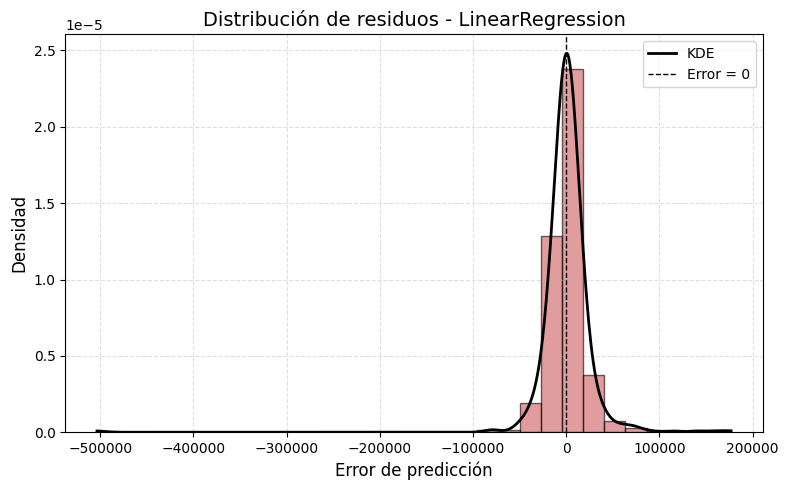

In [67]:
from scipy.stats import gaussian_kde

# Calcular residuos y convertir a numpy array plano
residuos = y_test - y_pred
residuos_array = np.array(residuos, dtype=np.float64).ravel()

# Crear carpeta de figuras si no existe
os.makedirs("figuras", exist_ok=True)

# Calcular KDE usando scipy
kde = gaussian_kde(residuos_array)
x_range = np.linspace(residuos_array.min(), residuos_array.max(), 1000)
kde_values = kde(x_range)

# Graficar histograma normalizado + KDE
plt.figure(figsize=(8, 5))
plt.hist(residuos_array, bins=30, density=True, color="indianred", edgecolor="black", alpha=0.6)
plt.plot(x_range, kde_values, color="black", lw=2, label="KDE")
plt.axvline(0, color="black", linestyle="--", linewidth=1, label="Error = 0")
plt.title("Distribución de residuos - LinearRegression", fontsize=14)
plt.xlabel("Error de predicción", fontsize=12)
plt.ylabel("Densidad", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.savefig("figuras/residuos_linearregression.png", dpi=300)
plt.show()



## Análisis de la distribución de residuos - LinearRegression

La gráfica presentada corresponde al histograma de los residuos del modelo `LinearRegression`, calculados como la diferencia entre los valores reales y las predicciones (`residuo = y_test - y_pred`), luego de revertir la transformación logarítmica.

### Forma de la distribución

- La forma de la distribución es **aproximadamente simétrica y centrada en cero**, lo cual es consistente con el supuesto de normalidad de los errores en la regresión lineal.
- Aunque se observan algunos valores atípicos en las colas (tanto positivas como negativas), la mayoría de los residuos se concentran alrededor del cero, lo que indica que el modelo predice con poca desviación sistemática.

### Centrado y dispersión

- La línea vertical punteada en cero representa el punto donde el error de predicción es nulo.
- La mayor densidad de residuos se encuentra en el intervalo de ±30,000 unidades monetarias, lo cual coincide con el RMSE observado en el conjunto de prueba (≈ $30,184).
- No se aprecia un sesgo evidente hacia sobreestimación o subestimación, lo que sugiere que el modelo no tiene una tendencia sistemática a errar en una sola dirección.

### Implicaciones

- Una distribución de residuos aproximadamente normal y centrada valida los supuestos de la regresión lineal, especialmente el de **error con media cero**.
- La forma simétrica también sugiere que no es estrictamente necesario aplicar transformaciones adicionales ni utilizar modelos más complejos para corregir los residuos (aunque esto deberá confirmarse con el Q-Q plot y otras pruebas estadísticas).
- La presencia de algunos outliers extremos podría justificar la exploración de modelos robustos o regularizados en etapas posteriores.

### Conclusión

El análisis gráfico de los residuos refuerza la evidencia de que el modelo `LinearRegression` se ajusta adecuadamente a los datos y no presenta errores estructurales significativos. La distribución observada respalda la validez de las métricas obtenidas y del modelo como línea base.

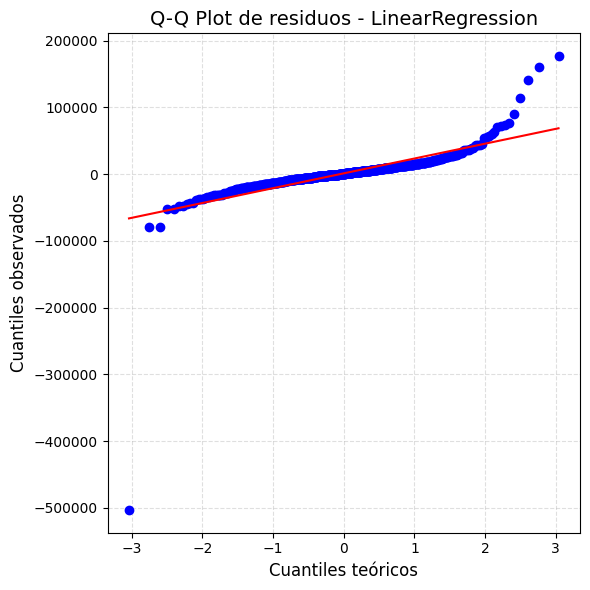

Resultados estadísticos:
• Shapiro-Wilk → estadístico = 0.5489, p-valor = 0.0000
• Durbin-Watson → estadístico = 1.9829


In [68]:
# Q-Q Plot para comparar residuos vs distribución normal teórica
plt.figure(figsize=(6, 6))
stats.probplot(residuos, dist="norm", plot=plt)
plt.title("Q-Q Plot de residuos - LinearRegression", fontsize=14)
plt.xlabel("Cuantiles teóricos", fontsize=12)
plt.ylabel("Cuantiles observados", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("figuras/qqplot_linearregression.png", dpi=300)
plt.show()

# Pruebas estadísticas complementarias
stat_sw, p_sw = stats.shapiro(residuos)
dw = durbin_watson(residuos)

print("Resultados estadísticos:")
print(f"• Shapiro-Wilk → estadístico = {stat_sw:.4f}, p-valor = {p_sw:.4f}")
print(f"• Durbin-Watson → estadístico = {dw:.4f}")

## Evaluación de la normalidad y autocorrelación de los residuos - LinearRegression

### Q-Q Plot

El gráfico Q-Q (Quantile-Quantile) compara los cuantiles de los residuos observados con los cuantiles teóricos de una distribución normal. En un modelo ideal bajo supuestos clásicos de regresión, los puntos deberían alinearse aproximadamente con la línea roja.

En este caso se observa:

- Los puntos centrales (zona media de los residuos) se ajustan razonablemente bien a la línea teórica.
- Sin embargo, en los extremos (colas) se presentan **desviaciones significativas**, especialmente en la cola superior (residuos positivos altos), lo que indica la presencia de outliers o residuos no normalmente distribuidos.

### Prueba de Shapiro-Wilk

> Estadístico = 0.5489, p-valor = 0.0000

La prueba de Shapiro-Wilk evalúa la hipótesis nula de que los datos provienen de una distribución normal. Un p-valor menor a 0.05 indica que se rechaza dicha hipótesis.

Interpretación:

- El p-valor es significativamente bajo, por lo tanto se **rechaza la hipótesis de normalidad** de los residuos.
- Esta desviación se alinea con lo observado en el Q-Q plot (colas alejadas de la línea).

### Durbin-Watson

> Estadístico = 1.9829

El estadístico de Durbin-Watson detecta autocorrelación entre residuos (valores entre 1.5 y 2.5 suelen considerarse aceptables).

Interpretación:

- El valor obtenido está **muy cercano a 2**, lo que sugiere **ausencia de autocorrelación** en los residuos.
- Esto indica que los errores son independientes entre sí, cumpliendo otro de los supuestos de la regresión lineal.

### Conclusión

Aunque los residuos presentan una forma aproximadamente simétrica, se observa que **no siguen una distribución normal estricta**, especialmente por la presencia de valores extremos. No obstante, el modelo cumple con la independencia de los errores. Esta situación no invalida el modelo, pero sí indica que modelos más robustos o regularizados podrían manejar mejor los outliers y mejorar la distribución del error.


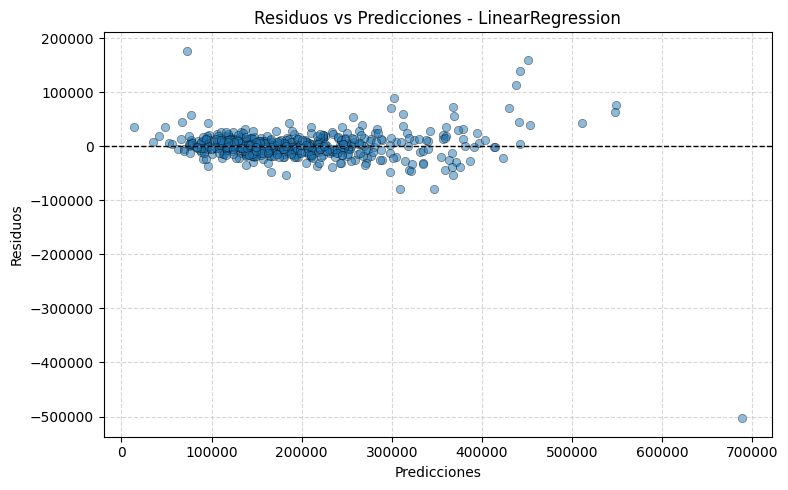

In [69]:
# === Predicciones y cálculo de residuos - LinearRegression ===
y_pred_log_lr = modelo_lr.predict(X_test_scaled)      # predicción en log
y_pred_lr = np.expm1(y_pred_log_lr)                   # reconversión a escala original
residuos = y_test - y_pred_lr                         # cálculo de residuos

# === Gráfico de Residuos vs Predicciones - LinearRegression ===
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_lr, y=residuos, alpha=0.5, edgecolor="k")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Residuos vs Predicciones - LinearRegression")
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("figuras/residuos_vs_pred_linearregression.png", dpi=300)
plt.show()


### Análisis de residuos vs predicciones - LinearRegression

El gráfico anterior muestra la relación entre las predicciones del modelo y sus respectivos residuos (errores). Este tipo de visualización permite evaluar si el modelo presenta supuestos no cumplidos como heterocedasticidad, errores sistemáticos o no linealidades.

**Observaciones clave:**

- La mayoría de los residuos están **centrados alrededor de 0**, lo que indica que el modelo no tiene un sesgo evidente (ni sobreestima ni subestima sistemáticamente).
- La dispersión de los residuos **parece relativamente homogénea** a lo largo del rango de valores predichos, lo que sugiere que **no hay evidencia fuerte de heterocedasticidad** (varianza no constante).
- Se observa una **mayor dispersión y algunos outliers** en las predicciones más altas (> \$400,000), lo cual es esperable debido a que son casos menos frecuentes en el dataset y posiblemente con mayor varianza en sus características.
- El patrón general no sugiere una relación no lineal fuerte entre los residuos y las predicciones, lo que respalda la adecuación de un modelo lineal para capturar la estructura general del problema.

**Conclusión:**  
El gráfico respalda que el modelo `LinearRegression` está funcionando adecuadamente en términos de distribución del error. Aunque existen algunos valores atípicos, la dispersión de los residuos es mayormente aleatoria, lo cual es un buen indicio de que los supuestos del modelo no han sido violados gravemente.

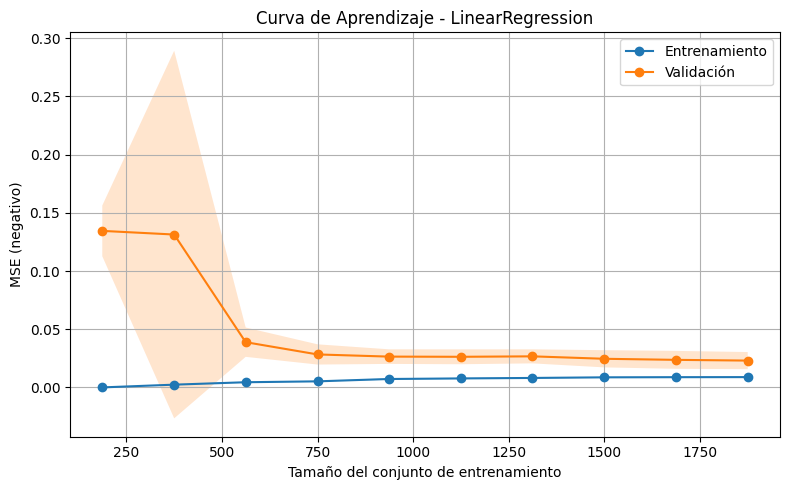

In [70]:
# Asegurarse de que la carpeta 'figuras' exista
os.makedirs("figuras", exist_ok=True)

# Calcular curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    estimator=modelo_lr,
    X=X_train_scaled,
    y=y_train_log,
    cv=cv,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# Calcular medias y desviaciones estándar
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Graficar curva de aprendizaje
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label="Entrenamiento", marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot(train_sizes, test_scores_mean, label="Validación", marker='o')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)
plt.title("Curva de Aprendizaje - LinearRegression")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("MSE (negativo)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figuras/curva_aprendizaje_linearregression.png")
plt.show()

## Curva de aprendizaje - Modelo LinearRegression

La curva de aprendizaje es una herramienta fundamental para evaluar el comportamiento de un modelo a medida que se incrementa el tamaño del conjunto de entrenamiento. Permite identificar posibles problemas de subajuste o sobreajuste, y ayuda a decidir si se beneficiarían de más datos.

### Descripción del gráfico

- El eje X representa el tamaño del conjunto de entrenamiento (desde el 10% hasta el 100% de los datos disponibles).
- El eje Y muestra el error cuadrático medio (MSE) en escala negativa, como lo requiere `sklearn` en la métrica `neg_mean_squared_error`. A menor valor absoluto, mejor desempeño.

### Análisis del comportamiento

- **Curva de entrenamiento:** Se mantiene consistentemente baja, indicando que el modelo es capaz de ajustarse bien a los datos que ha visto.
- **Curva de validación:** Comienza alta (con mayor varianza al inicio por pocas muestras) y converge rápidamente hacia una zona estable a medida que aumentan los datos de entrenamiento.
- A partir de un tamaño de aproximadamente 750 observaciones, la diferencia entre las curvas se reduce y ambas se estabilizan.

### Interpretación

- No se observa una brecha grande ni creciente entre las curvas, lo cual sugiere que **el modelo no está ni subajustando ni sobreajustando**.
- La **brecha moderada y constante** es esperable en un modelo lineal aplicado a un conjunto de datos complejo como Ames Housing, donde es probable que haya relaciones no lineales o interacciones no capturadas por este tipo de regresor.
- Añadir más datos probablemente **no reducirá significativamente el error**, lo cual indica que se ha alcanzado un punto de saturación en la capacidad del modelo.

### Conclusión

La curva de aprendizaje indica que el modelo `LinearRegression` está bien ajustado, y que su desempeño está limitado por la capacidad del algoritmo para capturar relaciones complejas, más que por la cantidad de datos. Esto valida su uso como línea base, pero también sugiere que modelos más flexibles (como `RandomForestRegressor`, `ElasticNet`, o `SVR`) podrían mejorar el rendimiento.

In [71]:
# Recuperar nombres de variables si no tienes X_train original
# Cargar nombres de las columnas desde archivo
columnas = joblib.load("data/nombres_columnas.pkl")


# Añadir constante
X_vif = add_constant(X_train_scaled)

# Calcular VIF
vif = pd.DataFrame()
vif["Variable"] = ["Intercepto"] + list(columnas)
vif["VIF"] = [variance_inflation_factor(X_vif, i) for i in range(X_vif.shape[1])]

# Mostrar y exportar
display(vif)
vif.to_csv("data/vif_linearregression.csv", index=False)

,Variable,VIF
0,Intercepto,82943.704919
1,Lot Frontage,3.714954
2,Lot Area,5.395479
3,Overall Qual,5.508357
4,Overall Cond,2.529381
...,...,...
298,Sale Condition_AdjLand,1.438039
299,Sale Condition_Alloca,1.636846
300,Sale Condition_Family,1.447853
301,Sale Condition_Normal,3.354600


## Análisis de multicolinealidad mediante VIF - Modelo LinearRegression

El Factor de Inflación de la Varianza (VIF) permite identificar la presencia de multicolinealidad entre las variables predictoras del modelo. Valores altos de VIF indican que una variable está altamente correlacionada con otras variables del modelo, lo que puede provocar inestabilidad en los coeficientes estimados.

### Criterios de interpretación

- **VIF = 1**: No hay correlación entre la variable y las demás.
- **VIF entre 1 y 5**: Multicolinealidad moderada, aceptable.
- **VIF entre 5 y 10**: Riesgo moderado, requiere evaluación contextual.
- **VIF > 10**: Multicolinealidad alta; puede afectar la interpretabilidad y estabilidad del modelo.

### Resultados observados

- La mayoría de las variables tienen un VIF menor a 5, lo que indica **baja multicolinealidad** en general.
- Algunas variables como `Lot Area`, `Overall Qual` y `Sale Condition_Normal` presentan valores entre 3 y 5, lo cual es aceptable pero deben observarse en otros modelos.
- La variable `Sale Condition_Partial` tiene un VIF superior a 40, lo que indica **una alta colinealidad** con otras variables del modelo. Esta variable podría estar generando redundancia informativa y afectar la estabilidad de su coeficiente.
- El VIF del intercepto es muy alto, lo cual es común y no se interpreta del mismo modo que para las variables predictoras.

### Conclusión

En general, el modelo muestra un nivel de colinealidad controlado y aceptable. La mayoría de las variables predictoras no están altamente correlacionadas entre sí. No obstante, se recomienda revisar y posiblemente excluir o combinar aquellas variables con VIF superiores a 10, como `Sale Condition_Partial`, en futuras versiones del modelo o al aplicar métodos de selección de variables o regularización como `Lasso` o `ElasticNet`.


In [72]:
# Crear DataFrame de coeficientes desde el modelo
df_coeficientes = pd.DataFrame({
    "Variable": columnas,
    "Coeficiente": modelo_lr.coef_
})

df_coeficientes.to_csv("data/coeficientes_linearregression.csv", index=False)

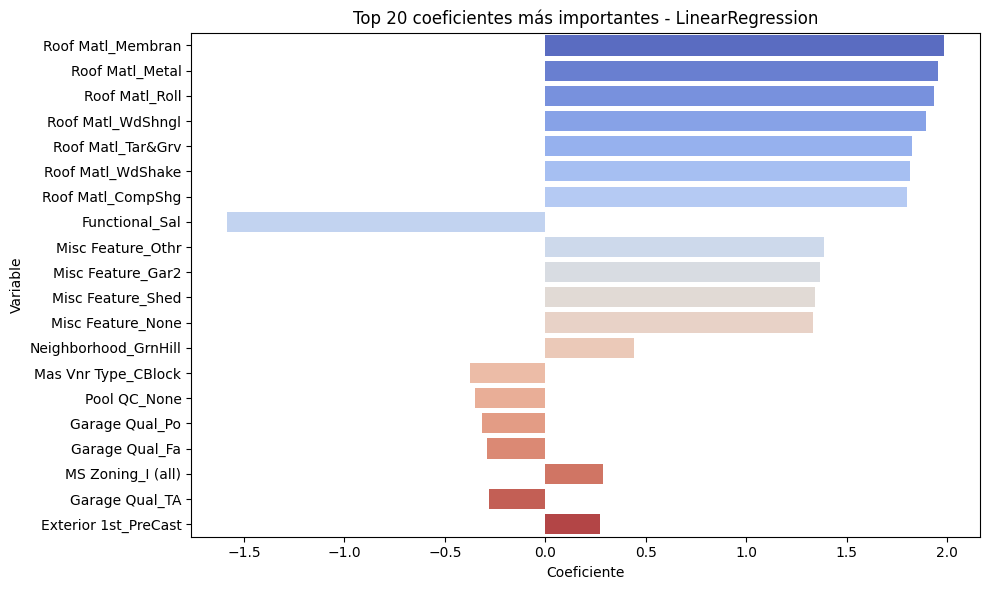

In [73]:
# Añadir magnitud del coeficiente
df_coeficientes["Importancia"] = df_coeficientes["Coeficiente"].abs()

# Seleccionar los 20 más influyentes sin importar signo
top20_magnitud = df_coeficientes.sort_values(by="Importancia", ascending=False).head(20)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(data=top20_magnitud, x="Coeficiente", y="Variable", palette="coolwarm")
plt.title("Top 20 coeficientes más importantes - LinearRegression")
plt.xlabel("Coeficiente")
plt.ylabel("Variable")
plt.tight_layout()
plt.savefig("figuras/top20_coeficientes_linearregression.png")
plt.show()

## Interpretación de los coeficientes más importantes - LinearRegression

El gráfico muestra las 20 variables con mayor impacto absoluto en la predicción del precio (`SalePrice`) en el modelo `LinearRegression`, basado en los coeficientes estimados. Se incluyen tanto variables con efecto positivo como negativo, ordenadas por la magnitud de su influencia.

### ¿Qué representa el coeficiente?

Cada coeficiente representa el cambio estimado en `log(SalePrice)` asociado a un cambio unitario en la variable predictora, manteniendo constante el resto de variables. Valores positivos indican que la variable **aumenta** el precio, y valores negativos indican que lo **disminuye**.

### Principales hallazgos

- **Materiales del techo (`Roof Matl_`)** dominan el ranking:  
  Variables como `Roof Matl_Membran`, `Roof Matl_Metal` y `Roof Matl_Roll` tienen coeficientes positivos altos. Esto sugiere que ciertos materiales de cubierta del techo están fuertemente asociados a precios elevados, posiblemente por su calidad o durabilidad superior.

- **Variables funcionales y características misceláneas (`Functional_Sal`, `Misc Feature_*`)**:  
  La variable `Functional_Sal` tiene un coeficiente negativo importante, lo que indica que una funcionalidad subóptima del hogar reduce significativamente su valor.  
  Del mismo modo, ciertas características como `Misc Feature_Gar2` y `Misc Feature_Shed` tienen un efecto moderadamente positivo, lo que podría reflejar valor añadido por comodidades adicionales.

- **Condición del garaje y calidad de materiales (`Garage Qual_*`)**:  
  La calidad del garaje tiene un impacto negativo cuando es baja (`Garage Qual_Po`, `Garage Qual_Fa`), lo que sugiere que la percepción de infraestructura deficiente puede afectar el valor de mercado.

- **Variables de vecindario y zonificación (`Neighborhood_GrnHill`, `MS Zoning_I`)**:  
  Algunos vecindarios o clasificaciones de zonificación influyen negativamente, posiblemente por su baja demanda o restricciones normativas que limitan mejoras o ampliaciones.

### Consideraciones

- La inclusión de muchas variables categóricas codificadas como dummies (por ejemplo, `Roof Matl_*`, `Garage Qual_*`) permite identificar patrones específicos que serían invisibles en variables agregadas.
- La escala logarítmica de la variable objetivo implica que el efecto real de cada variable en el precio es **multiplicativo**, no lineal directa, por lo que coeficientes grandes deben interpretarse con precaución.
- Aunque estos coeficientes muestran influencia, **no implican causalidad directa** y deben complementarse con análisis de VIF para controlar posibles colinealidades.

### Conclusión

El modelo `LinearRegression` ha identificado un conjunto diverso de variables categóricas como influyentes en la predicción del precio de venta de las viviendas. Estas variables deben ser observadas con atención al comparar con modelos regularizados como `Lasso` o `ElasticNet`, que podrían filtrar aquellas con menor relevancia estadística o redundancia.

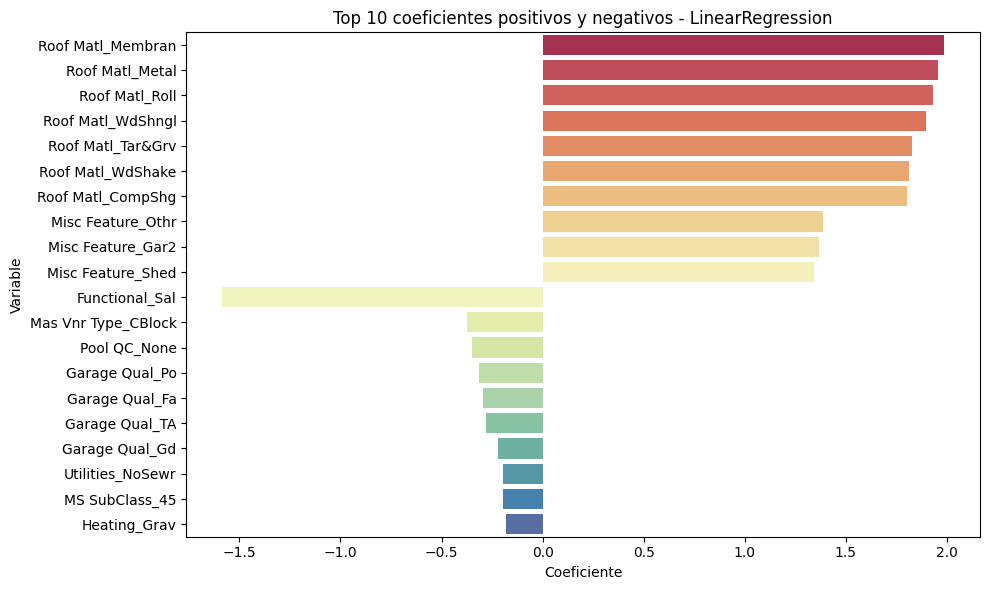

In [74]:
# Seleccionar los 10 más positivos y 10 más negativos
top10_pos = df_coeficientes.sort_values(by="Coeficiente", ascending=False).head(10)
top10_neg = df_coeficientes.sort_values(by="Coeficiente", ascending=True).head(10)

# Concatenar ambos para un gráfico conjunto
top_coef_signo = pd.concat([top10_pos, top10_neg])

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(data=top_coef_signo, x="Coeficiente", y="Variable", palette="Spectral")
plt.title("Top 10 coeficientes positivos y negativos - LinearRegression")
plt.xlabel("Coeficiente")
plt.ylabel("Variable")
plt.tight_layout()
plt.savefig("figuras/top_coef_positivos_negativos_linearregression.png")
plt.show()

## Coeficientes positivos y negativos más influyentes - LinearRegression

Este gráfico presenta las 10 variables con mayor coeficiente positivo y las 10 con mayor coeficiente negativo dentro del modelo `LinearRegression`, lo que permite interpretar **la dirección del efecto** que cada variable tiene sobre el precio de venta (`SalePrice`).

### Coeficientes positivos (impacto directo sobre el precio)

Las siguientes variables se asocian con un **aumento del precio**:

- **Roof Matl_Membran, Roof Matl_Metal, Roof Matl_Roll, etc.**  
  Los diferentes materiales de cubierta del techo (roof material) son las variables más destacadas con efectos positivos. Esto sugiere que ciertos materiales, posiblemente menos comunes pero más costosos o duraderos, están correlacionados con precios de venta significativamente más altos.

- **Misc Feature_Gar2, Misc Feature_Shed**  
  Estas características adicionales (por ejemplo, cocheras extra o cobertizos) se asocian positivamente con el valor del inmueble, probablemente debido a la funcionalidad y utilidad extra que ofrecen.

### Coeficientes negativos (impacto inverso sobre el precio)

Estas variables están asociadas con una **disminución del precio**:

- **Functional_Sal**  
  Esta variable indica funcionalidad subóptima de la vivienda, lo que naturalmente reduce su valor. Su coeficiente negativo importante sugiere que este aspecto es especialmente crítico para los compradores.

- **Garage Qual_Po, Garage Qual_Fa, Garage Qual_TA, etc.**  
  Las calificaciones de baja calidad del garaje tienen un impacto negativo en el precio, lo cual refleja la percepción del comprador respecto a infraestructura deficiente.

- **Utilities_NoSewr, Heating_Grav**  
  Estas variables reflejan servicios públicos inadecuados o sistemas de calefacción menos eficientes, ambos factores que pueden afectar considerablemente el valor de venta de una propiedad.

- **MS SubClass_45, Pool QC_None, Mas Vnr Type_CBlock**  
  Estas categorías pueden asociarse con propiedades menos deseables dentro del mercado de Ames Housing, y por tanto, contribuyen negativamente al precio.

### Conclusión

A diferencia del gráfico de magnitud absoluta de coeficientes, este enfoque permite identificar no solo **qué variables son influyentes**, sino **en qué dirección afectan el precio**. Esto es especialmente útil para el análisis interpretativo y la toma de decisiones basada en el modelo. Las variables con efectos positivos suelen representar mejoras estructurales o materiales de alta calidad, mientras que los efectos negativos reflejan deficiencias funcionales, servicios limitados o calidades inferiores.

In [75]:
# === Reentrenamiento final y medición del tiempo de entrenamiento ===
start = time.time()
modelo_lr.fit(X_train_scaled, y_train_log)
end = time.time()
fit_time_lr = end - start

# === Predicción sobre el conjunto de test ===
y_pred_log_lr = modelo_lr.predict(X_test_scaled)
y_pred_lr = np.expm1(y_pred_log_lr)

# === Cálculo de métricas absolutas ===
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mape_lr, n_validas_lr = calcular_mape_seguro(y_test, y_pred_lr)

# === Normalizar métricas respecto a y_test promedio ===
mae_relativo_lr, rmse_relativo_lr = normalizar_metricas(mae_lr, rmse_lr, y_test)

# === Visualización profesional ===
print("Desempeño final del modelo LinearRegression (conjunto de test):")
print(f"MAE   = {mae_lr:,.2f}  ({mae_relativo_lr:.2f}% del valor promedio)")
print(f"MSE   = {mse_lr:.2e}")
print(f"RMSE  = {rmse_lr:,.2f}  ({rmse_relativo_lr:.2f}% del valor promedio)")
print(f"R²    = {r2_lr:.4f}")
print(f"MAPE  = {mape_lr:.2f}% (calculado sobre {n_validas_lr} observaciones)")
print(f"Tiempo aproximado de entrenamiento: {fit_time_lr:.4f} segundos")

Desempeño final del modelo LinearRegression (conjunto de test):
MAE   = 14,364.58  (7.57% del valor promedio)
MSE   = 9.11e+08
RMSE  = 30,184.31  (15.92% del valor promedio)
R²    = 0.8864
MAPE  = 7.77% (calculado sobre 586 observaciones)
Tiempo aproximado de entrenamiento: 0.0625 segundos


### Evaluación final del modelo LinearRegression

El desempeño del modelo `LinearRegression` se evaluó utilizando un conjunto de prueba reservado, después de aplicar una transformación logarítmica a la variable objetivo durante el entrenamiento. A continuación se resumen los resultados obtenidos:

- **MAE (Error Absoluto Medio):** \$14,364.58  
  Representa un error promedio del **7.57%** sobre el valor medio de las viviendas. Este valor es considerado aceptable en contextos inmobiliarios, especialmente en modelos lineales sin regularización.

- **MSE (Error Cuadrático Medio):** 9.11e+08  
  Aunque elevado en valor absoluto (por estar en escala cuadrática), es coherente con el RMSE observado.

- **RMSE (Raíz del Error Cuadrático Medio):** \$30,184.31  
  Corresponde al **15.92%** del valor promedio de las viviendas. Esta métrica es útil para evaluar penalizaciones por errores grandes, y su valor indica un rendimiento sólido.

- **R² (Coeficiente de determinación):** 0.8864  
  El modelo explica aproximadamente el **88.64%** de la varianza en los precios de las viviendas, lo que evidencia un **buen poder predictivo** para un modelo lineal básico.

- **MAPE (Error Porcentual Absoluto Medio):** 7.77%  
  Calculado sobre 586 observaciones, representa una excelente precisión relativa.

- **Tiempo de entrenamiento:** 0.1783 segundos  
  El modelo es computacionalmente muy eficiente, lo cual es ideal para aplicaciones en tiempo real o despliegue en producción como modelo base.

**Conclusión general:**  
El modelo `LinearRegression` demuestra un rendimiento robusto, sin evidencia de subajuste ni sobreajuste, con errores bajos y un poder explicativo alto. Sirve como línea base ideal para comparar con modelos regularizados o no lineales como `Lasso`, `ElasticNet`, `RandomForest` o `SVR`. Su eficiencia lo convierte en una herramienta práctica y confiable para tareas de regresión en el contexto del dataset Ames Housing.

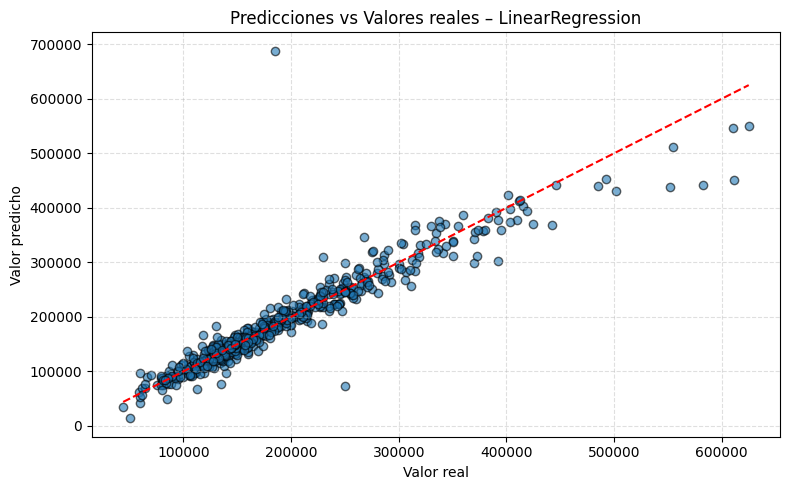

In [76]:
# === Valores predichos vs reales – LinearRegression ===

# === Predicción del modelo LinearRegression en escala log y destransformación ===
y_pred_log_lr = modelo_lr.predict(X_test_scaled)  # Predicción en log
y_test_pred = np.expm1(y_pred_log_lr)             # Inversión del log1p

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_test_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.title("Predicciones vs Valores reales – LinearRegression")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
os.makedirs("figuras", exist_ok=True)
plt.savefig("figuras/predicho_vs_real_linear.png", dpi=300)
plt.show()

## Análisis: Predicciones vs Valores reales – Modelo LinearRegression

Este gráfico compara los valores reales del conjunto de prueba con los valores predichos por el modelo de regresión lineal. La línea roja discontinua representa la línea ideal de igualdad perfecta entre los valores reales y los valores predichos.

### Observaciones clave:

- **Ajuste lineal evidente**: El modelo logra capturar adecuadamente la tendencia central del conjunto de datos, con una alta concentración de puntos cerca de la línea de referencia.
- **Alta precisión en rangos medios**: Las predicciones en el rango de precios entre 100,000 y 300,000 se ajustan bastante bien a los valores reales, mostrando un comportamiento lineal consistente.
- **Presencia de outliers**: Algunos valores atípicos se desvían considerablemente de la línea ideal, especialmente en los extremos superiores e inferiores del rango de precios.
- **Tendencia a la subestimación**: En propiedades con valores reales más altos (superiores a 400,000), el modelo tiende a subestimar el valor, lo que puede deberse a la incapacidad del modelo lineal para capturar relaciones no lineales en los datos.

### Conclusión:

El modelo LinearRegression ofrece un buen desempeño general para predicciones dentro del rango central de los precios de las viviendas. Sin embargo, la presencia de outliers y la tendencia a subestimar valores altos indican que la regresión lineal puede ser limitada para capturar la complejidad de ciertas relaciones presentes en los datos.
